In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt, log, e
from scipy.stats import norm

In [2]:
def binomial_lattice(S0, K, r, v, T, n, call_put, exercise_policy):    
    time_step = T/n
    
    # Compute u and d
    """ Fill in appropriate formulas    DONE"""
    u = pow(e, v * sqrt(time_step))
    d = pow(e, -v * sqrt(time_step))
    
    # Compute p and q 
    """ Fill in appropriate formulas      DONE"""
    p = ((pow(e, r * time_step)) -d) / (u - d)
    q = 1 - p   
    
    # Create empty matrix for stock prices
    stock_price = np.zeros((n+1,n+1))
    
    # Set initial stock price
    stock_price[0,0] = S0
    
    # Fill matrix with stock prices per time step
    for i in range(1, n+1):
        stock_price[i,0] = stock_price[i-1,0]*u
        for j in range(1, i+1):
            stock_price[i,j] = stock_price[i-1,j-1]*d
    
    # Transform numpy matrix into Pandas Dataframe
    df_stock_price = pd.DataFrame(data=stock_price)
    df_stock_price = df_stock_price.T
    
    # Create empty matrix for option values
    option_value = np.zeros((n+1,n+1))
    
    # For final time step, compute option value based on stock price and strike price
    for i in range(n+1):
        if call_put == 'Call':
            """Fill in appropriate formula DONE"""
            option_value[n,i] = max(0, stock_price[n,i] - K)
        elif call_put == 'Put':
            """Fill in appropriate formula DONE"""
            option_value[n,i] =  max(0, K -  stock_price[n,i] )
            
    # Compute discount factor per time step
    """Fill in appropriate formula DONE"""
    discount = pow(e, -r * time_step)
    
    # Recursively compute option value at time 0
    if (call_put == 'Call' or call_put == 'Put') and exercise_policy == 'European':
        for i in range(n-1,-1,-1):
            for j in range(i+1):
                """ Fill in appropriate formulas for the different option types DONE"""
                option_value[i,j] = (option_value[i+1,j]*p + option_value[i+1,j+1] * q ) * discount
        
    elif call_put == 'Put' and exercise_policy == 'American':
        for i in range(n-1,-1,-1):
            for j in range(i+1):
                """ Fill in appropriate formulas for the different option types"""
                holdingPaper = (option_value[i+1,j]*p + option_value[i+1,j+1] * q ) * discount
                exerciseNow = K - stock_price[i,j]
                option_value[i,j] = max (holdingPaper, exerciseNow)

    
            
    df_option_value = pd.DataFrame(data=option_value)
    df_option_value = df_option_value.T
    
    return option_value[0,0], df_stock_price, df_option_value

# S0 = 1 # Stock price
# K = 1 # Strike price
# v = 1 # Volatility
# T = 1 # Time horizon
# r = 1 # Risk-free rate
# n = 10 # Number of time steps
# call_put = 'Call' # Option type ('Call' or 'Put')
# exercise_policy = 'European' # Option type ('European' or 'American')


# Test case: the following settings should yield an option price of 4.04
# S0 = 100 
# K = 105
# v = 0.1
# T = 1
# r = 0.05
# n = 10
# # call_put = 'Call'
# exercise_policy = 'European'



#works 
#example of slides and 
S0 = 36 # Stock price
K = 40 # Strike price
v = 0.4 # Volatility
T = 90/365 # Time horizon
r = 0.1 # Risk-free rate
n = 3 # Number of time steps
# call_put = 'Call' # Option type ('Call' or 'Put')  European call gives 1.51
call_put = 'Put' # Option type ('Call' or 'Put') European put gives 4.54
# exercise_policy = 'European' # Option type ('European' or 'American') 
exercise_policy = 'American' # Option type ('European' or 'American') American Put gives 4.84





binomial_price, df,df_option = binomial_lattice(S0, K, r, v, T, n, call_put, exercise_policy)

print ('Binomial lattice price: %.2f' % binomial_price)
print("\n stockprices: \n")
print(df)
print("\n optionvalues: \n")
print (df_option)

Binomial lattice price: 4.84

 stockprices: 

      0          1          2          3
0  36.0  40.374378  45.280289  50.782319
1   0.0  32.099566  36.000000  40.374378
2   0.0   0.000000  28.621726  32.099566
3   0.0   0.000000   0.000000  25.520693

 optionvalues: 

          0         1          2          3
0  4.844424  1.954797   0.000000   0.000000
1  0.000000  7.900434   4.000000   0.000000
2  0.000000  0.000000  11.378274   7.900434
3  0.000000  0.000000   0.000000  14.479307


## Computing Vega
The Black-Scholes formula depends on a number of variables, for which derivatives can be computed. These so-called 'Greeks' serve as measures of the option price's sensitivity with respect to its input. The Greek Vega ${\mathcal {V}}$ indicates the sensitivity of the option value with respect to its volatility.

https://en.wikipedia.org/wiki/Greeks_(finance)#Vega

Understanding of the Greeks is not expected for the purpose of Module 5. As the Newton-Raphson method depends on a derivative of the function of interest, we utilize Vega as this derivative. The intuition is that, if we observe a large difference between computed price and target price, we perform a larger update on the implied volatility. The closer we get to the target, the smaller the updates become.



In [3]:
def black_scholes_vega(S, K, T, r, v):
    d1 = (log(S / K) + (r + 0.5 * v ** 2) * T) / (v * sqrt(T))
    return S * norm.pdf(d1) * sqrt(T)

## Newton-Raphson method
In Excel, a built-in Solver is provided to find the solutions to equations. In Python, no such solver is provided by default. To find the implied volatility, you may use the function find_implied_volatility that is described below. It is an numerical solution method that applies the Newton-Raphson method on the derivative of the Black-Scholes formula, specifically the Vega.

https://en.wikipedia.org/wiki/Newton%27s_method

In general form, the Newton-Raphson method may be described as follows:

$x_{n+1}=x_{n}-{\frac {f(x_{n})}{f'(x_{n})}}$

Once again, an understanding of the method is not expected. The intuition is that the method performs a number of iterations to estimate the implied volatility. It starts with a certain estimate for the implied volatility, computes the lattice price with that volatility, and computes the error with the real market price. Subsequently, the volatility is updated in a direction that reduces the error. Each iteration should yield a smaller error between lattice- and real price, until the error falls below a predefined precision or the maximum number of iterations is reached. Note that convergence is not guaranteed. Also, it is good to realize that not every market price can be achieved, e.g., volatility cannot be negative.

Delving into the details a bit more: the Newton-Raphson method is a root-finding algorithm, i.e., it tries to find the point for which the function becomes 0. For visualisation purposes we use the Black-Scholes call function. By subtracting the market price $C^*(S,T)$ from our model estimate, we find the root when market price equals the model price. The derivative over volatility yields vega, note this derivative is equivalent for puts and calls. Formally, the procedure is defined as follows: 


$\sigma_{n+1}=\sigma_{n}-{\frac {N(d_{1})S-N(d_{2})Ke^{-rT}-C^*(S,T)}{S N'(d_{1}){\sqrt {T}}\,)}}$

s.t.

$\\d_{1}={\frac {1}{\sigma {\sqrt {T}}}}\left[\ln \left({\frac {S}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)T\right]\\d_{2}=d_{1}-\sigma {\sqrt {T}}$



In [4]:
"""Implied volatility is found using the Newton-Raphson method"""
def compute_implied_volatility(true_price, S, K, r, T, n, call_put, exercise_policy):
    MAX_NO_ITERATIONS = 100
    MAX_VOL_UPDATE = 0.1
    ACCURACY = 1.0e-5

    implied_vol = .5 # Initial estimate for implied volatility 
    
    for i in range(MAX_NO_ITERATIONS):
        # Compute price with binomial lattice, using current estimate for implied volatility
        model_price, _, _ = binomial_lattice(S, K, r, implied_vol, T, n, call_put, exercise_policy)
        
        # Compute difference between model price and market price (the root) 
        diff = model_price - true_price

        # Terminate algorithm if desired precision has been hit 
        if (abs(diff) < ACCURACY):
            return implied_vol
        
        # Update implied volatility based on vega and observed error
        vega = black_scholes_vega(S, K, T, r, implied_vol)

        implied_vol -= np.clip(diff/vega, -MAX_VOL_UPDATE, MAX_VOL_UPDATE)
        
    # If maximum number of iterations is hit, simply return best estimate so far
    return implied_vol

In [5]:
# Test case: the following settings should yield an implied volatility of 3.82%
S0 = 100 
K = 100
r = 0.05
v = 0.1
T = 1
n = 10
call_put = 'Call'
exercise_policy = 'European'

market_price = 5 # Set true market price of the option here

#Using here for exercise C to calculate implied volatility with Newton-Raphson method, 
#also determine it by Black-Scholes formula with the use of black_scholar_vega
# and depict the outcomes in a graph

# Input parameters
# S0 = 1 
# K = 1
# r = 1
# v = 1
# T = 1
# n = 10
# call_put = 'Call'
# exercise_policy = 'European'

# market_price = 1 # Set true market price of the option here

# Compute implied volatility using Newton-Raphson method
implied_vol = compute_implied_volatility(market_price, S0, K, r, T, n, call_put, exercise_policy)

# Compute binomial lattice price with implied volatility
binomial_price, _, _ = binomial_lattice(S0, K, r, implied_vol, T, n, call_put, exercise_policy)

print ('Implied volatility: %.2f%%' % (implied_vol * 100))
print ('True market price: %.2f' % market_price)
print ('Binomial lattice price: %.2f' % binomial_price)

Implied volatility: 3.81%
True market price: 5.00
Binomial lattice price: 5.00


## Sample plot
Basic example of an implied volatility plot. You will need to compute and store the appropriate implied volatilies yourself.

Real-world data for a Tesla call option is obtained from Marketbeat.com. If your binomial lattice is implemented correctly, you should be able to closely replicate the given implied volatilities (using T=3 days and S0=730).

Tesla Call
[0.5873770265088322, 0.5870566261985626, 0.5803376585465662, 0.5803834438054429, 0.5804290912279843, 0.5666683923744298, 0.5558175408576106, 0.551924259744427, 0.5497020400452702, 0.5421111489573662]


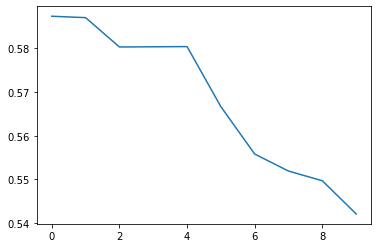

Ford Call
[0.8911829054249595, 0.7504562905932739, 0.6048499563211102, 0.5304477704536372, 0.4996033046772565, 0.47659752967457014, 0.4789224086703803, 0.48013158335991135, 0.5133965073804705, 0.5462746774703929]


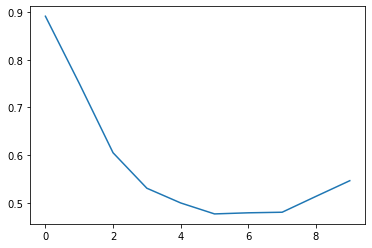

PriceLine Call
[0.452133244206032, 0.4465781170138561, 0.4448304467229555, 0.4435575237859023, 0.44689287526343763, 0.44540702182510766, 0.442277142844544, 0.4425386695693149, 0.47607919476938276, 0.43640070239454715]


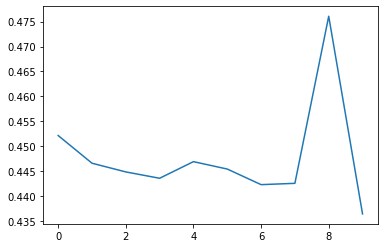

Expedia Call
[0.5809607240963334, 0.5541282283369646, 0.5518972493491062, 0.5441153324981253, 0.5214007747138308, 0.5230086430158497, 0.5223872493671232, 0.5111264086043177, 0.5052655653114618, 0.49777754545598135]


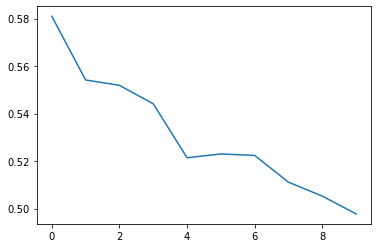

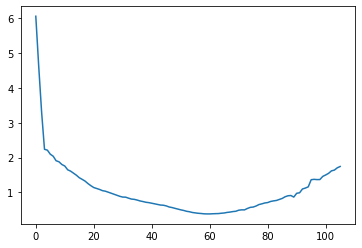

In [7]:
#Using here for exercise C to calculate implied volatility with Newton-Raphson method, 
#also determine it by Black-Scholes formula with the use of black_scholar_vega
# and depict the outcomes in a graph
#plot a graph here with the x-as the strike price and y-as the implied volatility

 #compute_implied_volatility(market_price, S0, K, r, T, n, call_put, exercise_polic
#market_price = 
# S0 = 36 # Stock price
# K = 40 # Strike price
# v = 0.4 # Volatility
# T = 90/365 # Time horizon
# r = 0.1 # Risk-free rate
# n = 3 # Number of time steps
# call_put = 'Call' # Option type ('Call' or 'Put')  European call gives 1.51
# # exercise_policy = 'European' # Option type ('European' or 'American') 

def printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy):
    implied_list = []
    for i in range(0,10):
        implied_vol = compute_implied_volatility(market_price[i], S0, Ks[i], r, T, n, call_put, exercise_policy)
        implied_list.append(implied_vol)
    print(implied_list)
    # Set x-values equal to number of implied volatilities
    x_values  = np.arange(len(implied_list) )
#     x_values  = np.array(Ks)
    # Set y-values equal to implied volatilities
    y_values = np.array(implied_list)
    # Plot volatility smile
    plt.plot(x_values, y_values)
    plt.show()

r = 0.0347
T = 1/12
n = 90
exercise_policy = 'European'
#Tesla 
S0 = 300.8
#tesla bids&Ask Call
market_price = [28.225,27.225,25.125, 24.7, 24.275, 20.375, 17.775,16.2,15.4, 13.3,12.625]
Ks = [286.67, 288.33, 291.67, 292.5, 293.33, 300, 305, 308.33, 310, 315, 316.67]
call_put = 'Call'
print("Tesla Call")
printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy)

# #tesla bids Put
# market_price = [13.15,13.75,15,15.35,15.7,18.55,21,22.75,23.65,26.45,27.5]
# Ks = [286.67, 288.33, 291.67, 292.5, 293.33, 300, 305, 308.33, 310, 315, 316.67]
# call_put = 'Put'
# print("Tesla Put")
# printPlot (market_price,S0,Ks,r,T,n,'Put',exercise_policy)


#Ford
S0 = 13.05
#bidsand ASk mean call
market_price = [5.1,3.65,2.68, 1.79,1.065,0.54, 0.165, 0.105, 0.055, 0.03, 0.035 ]
Ks = [8, 9.5,10.5,11.5, 12.5,13.5,15,15.5,16.5,17.5,18]
call_put = 'Call'
print("Ford Call")
printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy)

# #bidsand ASk mean call
# market_price = [0.01, 0.035, 0.08, 0.205, 0.475, 0.96, 2.07, 2.51, 3.45, 4.45, 4.95 ]
# Ks = [8, 9.5,10.5,11.5, 12.5,13.5,15,15.5,16.5,17.5,18]
# call_put = 'Put'
# print("Ford Put")
# printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy)

#PriceLine
S0 = 1806.7
#bidsand ASk mean call
market_price = [132.6, 119.55,106.1, 100.6, 96.05, 93.4, 90.55, 86.2, 88.8, 73.9, 72.45  ]
Ks = [1740,1760,1785, 1795, 1805, 1810, 1815, 1825, 1835, 1850, 1855]
call_put = 'Call'
print("PriceLine Call")
printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy)

#Expedia
S0 = 99.01
#bidsand ASk mean call
market_price = [15.725, 11.75, 10.375, 9.65, 7.1, 6.6, 6.075, 4.275, 3.5, 2.84, 2.26 ]
Ks = [85,90,92,93,97,98,99,103,105,107,109]
call_put = 'Call'
print("Expedia Call")
printPlot (market_price,S0,Ks,r,T,n,call_put,exercise_policy)



# Option prices for Tesla (maturity 24-9-2021)
market_price_list=[630.2, 530.35, 430.375, 330.375, 320.4, 310.4, 300.425, 290.375, 280.425, 270.425, 260.45, 250.425, 240.475,
               230.5, 220.525, 210.525, 200.575, 190.625, 180.625, 170.65, 160.7, 155.725, 150.75, 145.75, 140.825, 135.85, 
               130.875, 125.9, 120.925, 115.95, 111.025, 106.225, 101.275, 96.35, 91.575, 86.725, 81.85, 77.075, 72.3, 67.675, 
               63.025, 58.425, 53.875, 49.4, 45.25, 40.925, 36.425, 32.375, 28.3, 24.425, 20.7, 17.325, 14, 11.275, 8.625, 
               6.575, 4.875, 3.575, 2.505, 1.775, 1.265, 0.93, 0.67, 0.475, 0.37, 0.28, 0.245, 0.195, 0.17, 0.135, 0.155, 0.13, 
               0.09, 0.09, 0.08, 0.05, 0.045, 0.05, 0.04, 0.035, 0.025, 0.025, 0.02, 0.015, 0.015, 0.015, 0.02, 0.02, 0.015, 
               0.005, 0.01, 0.005, 0.01, 0.005, 0.005, 0.02, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 
               0.005]

# Strike prices for Tesla options
strike_price_list =[100, 200, 300, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 575,
               580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685,
               690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795,
               800, 805, 810, 815, 820, 825, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980,
               990, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400]

# Implied volatilities for Tesla options 
implied_vol_given_list = [6.06195, 4.63453, 3.31565, 2.23785, 2.21292, 2.0969, 2.03894, 1.90917, 1.87824, 1.80033, 1.75746, 
                            1.64899, 1.61048, 1.55225, 1.4933, 1.4209, 1.37375, 1.32376, 1.25259, 1.19155, 1.13842, 1.11119, 
                            1.08355, 1.04859, 1.03362, 1.0046, 0.975283, 0.945672, 0.91578, 0.885605, 0.864444, 0.86212, 
                            0.833109, 0.806976, 0.798624, 0.777865, 0.752547, 0.735303, 0.71525, 0.704378, 0.687509, 0.670471,
                            0.652818, 0.635525, 0.630238, 0.610985, 0.579973, 0.563646, 0.540851, 0.519835, 0.497734, 0.480298,
                            0.456357, 0.442986, 0.421857, 0.40999, 0.39917, 0.392333, 0.383535, 0.380422, 0.380413, 0.38469,
                            0.387874, 0.390514, 0.400084, 0.407405, 0.423622, 0.433224, 0.447941, 0.456497, 0.487009, 0.497606,
                            0.496388, 0.536827, 0.568876, 0.577966, 0.607786, 0.649774, 0.670145, 0.695238, 0.706566, 0.738175,
                            0.754913, 0.766931, 0.796122, 0.824908, 0.873169, 0.901724, 0.908989, 0.864698, 0.973104, 0.987591,
                            1.09743, 1.12328, 1.15919, 1.36356, 1.37417, 1.36704, 1.3681, 1.45891, 1.49971, 1.54655, 1.61797,
                            1.63936, 1.7055, 1.74364]


# Set x-values equal to number of implied volatilities
x_values  = np.arange(len(implied_vol_given_list)) 
# x_values  = np.array(strike_price_list)
# Set y-values equal to implied volatilities
y_values = np.array(implied_vol_given_list)

# Plot volatility smile
plt.plot(x_values, y_values)
plt.show()